# Building Block Tutorial

> How to assemble building blocks with templates

This tutorial shows how to use `chem_templates` building block assembly.

Building blocks are chemical subunits that can be assembled via easy chemistry. Building blocks are a simple way to combinatorially generate diverse compounds. The `chem_templates` building block functions allow us to assemble molecules from building blocks and screen building blocks, intermediate products, and the final molecule with specific `Template` filters.

In this example, we will look at the simple case of assembling a molecule from two building blocks - `BB1 + BB2 -> product`. 

We can accomplish this with the following steps:
1. define templates
2. create synthon library
3. define assembly schema
4. assemble molecules

## Define Templates

We need a template for each building block, as well as the final product. For simplicity, we will use Rule of 3 filters for the individual building blocks, and the Rule of 5 filters for the final molecule

In [ ]:
from chem_templates.utils import *
from chem_templates.chem import Molecule
from chem_templates.building_blocks import molecule_to_synthon, REACTION_GROUPS, ReactionUniverse
from chem_templates.assembly import AssemblyInputs, SynthonNode, SynthonLeafNode
from chem_templates.filter import RangeFunctionFilter, ValidityFilter, SingleCompoundFilter, SmartsFilter
from chem_templates.template import Template

from rdkit.Chem import rdMolDescriptors, Descriptors
from rdkit.Chem import Draw

In [ ]:
def hbd(molecule):
    return rdMolDescriptors.CalcNumHBD(molecule.mol)

def hba(molecule):
    return rdMolDescriptors.CalcNumHBA(molecule.mol)

def molwt(molecule):
    return rdMolDescriptors.CalcExactMolWt(molecule.mol)

def logp(molecule):
    return Descriptors.MolLogP(molecule.mol)

def rotb(molecule):
    return rdMolDescriptors.CalcNumRotatableBonds(molecule.mol)

In [ ]:
# building block
bb_template = Template([
    RangeFunctionFilter(hbd, 'hydrogen_bond_donors', None, 3),
    RangeFunctionFilter(hba, 'hydrogen_bond_acceptors', None, 3),
    RangeFunctionFilter(molwt, 'molecular_weight', None, 300),
    RangeFunctionFilter(logp, 'CLogP', None, 3),
    RangeFunctionFilter(rotb, 'rotatable_bonds', None, 3)
])

# full
full_template = Template([
    ValidityFilter(),
    SingleCompoundFilter(),
    RangeFunctionFilter(hbd, 'hydrogen_bond_donors', None, 5),
    RangeFunctionFilter(hba, 'hydrogen_bond_acceptors', None, 10),
    RangeFunctionFilter(molwt, 'molecular_weight', None, 500),
    RangeFunctionFilter(logp, 'CLogP', None, 5),
    SmartsFilter('[CX3](=O)[OX2H1]', 'carboxylic_acid', 
                 exclude=True, min_val=2, max_val=None), # at most 1 carboxylic acid in final molecule
    SmartsFilter('[CX3](=[OX1])OCC', 'carboxylic_ester', 
                 exclude=True, min_val=1, max_val=None) # no carboxylic acid reactive group in final molecule
])

## Create Synthon Library

Now we need to create a library of _synthons_. A synthon is a hypothetical molecule that represents a building block after reaction. Reactive groups are converted to placeholder molecules. Later, we will use the placeholders to simulate building block assembly. A single molecule can have multiple synthons.

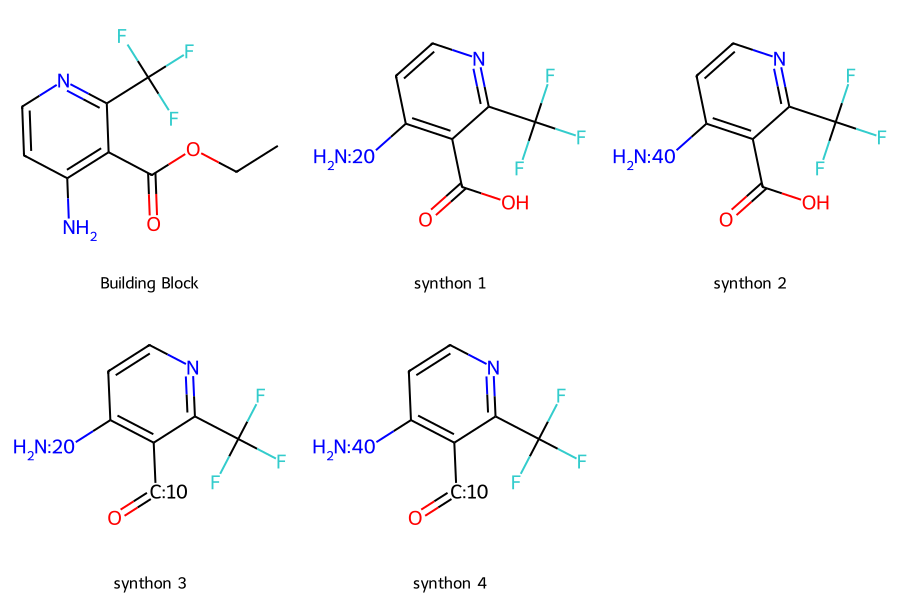

In [ ]:
molecule = Molecule('CCOC(=O)c1c(N)ccnc1C(F)(F)F')
synthons = molecule_to_synthon(molecule)
Draw.MolsToGridImage([molecule.mol]+[i.mol for i in synthons], 
                     legends=['Building Block'] + [f'synthon {i+1}' for i in range(len(synthons))],
                     subImgSize=(300,300))

In [ ]:
building_blocks = ['CCOC(=O)c1c(N)ccnc1C(F)(F)F',
 'COC(=O)C(C)N=C=O',
 'CCOC(=O)c1[nH]c2ccc(C)cc2c1N',
 'COC(=O)c1c(N)sc2c1CCC(C)C2',
 'O=C(NC[C@@H]1C[C@H](F)CN1)OCc1ccccc1',
 'O=C(NCC1CCNCC1)OCc1ccccc1',
 'NCC1CCCN(C(=O)OCc2ccccc2)C1',
 'CC(C)(CN)NC(=O)OCc1ccccc1',
 'O=C(NCC1CCCCN1)OCc1ccccc1',
 'C[C@@H]1CNCCN1C(=O)OCc1ccccc1',
 'NCC1CCN(C(=O)OCc2ccccc2)C1',
 'CCC1CNCCN1C(=O)OCc1ccccc1',
 'CNC1CCN(C(=O)OCc2ccccc2)CC1',
 'NC[C@@H]1CCN(C(=O)OCc2ccccc2)C1',
 'NC1CCN(C(=O)OCc2ccccc2)CC1F',
 'NC[C@H]1CCCN1C(=O)OCc1ccccc1',
 'N[C@@H]1C[C@H](C(=O)O)N(C(=O)OCc2ccccc2)C1',
 'O=C(OCc1ccccc1)N1CCN[C@H](Cc2ccccc2)C1',
 'O=C(OCc1ccccc1)N1CCC2(CCCCN2)C1',
 'O=C(OCc1ccccc1)N1CCCC2NCCC21',
 'C[C@H](N)C(=O)NCC1CCCCN1C(=O)OCc1ccccc1',
 'CC(C)[C@H](N)C(=O)N1CCCCC1CNC(=O)OCc1ccccc1',
 'NCC(=O)N1CCCC(CNC(=O)OCc2ccccc2)C1',
 'O=C(O)CN[C@@H]1CCCN(C(=O)OCc2ccccc2)C1',
 'CCN(C(=O)OCc1ccccc1)C1CCNCC1',
 'NCC(=O)NC[C@@H]1CCCN1C(=O)OCc1ccccc1',
 'C[C@H](N)C(=O)NC[C@@H]1CCCN1C(=O)OCc1ccccc1',
 'CCN(C(=O)OCc1ccccc1)[C@@H]1CCN(C(=O)CN)C1',
 'CCN(C(=O)OCc1ccccc1)[C@H]1CCN(C(=O)[C@H](C)N)C1',
 'CC(C)NC[C@@H]1CCCN1C(=O)OCc1ccccc1',
 'O=C(OCc1ccccc1)N(CC1CCNC1)C1CC1',
 'CCN(C(=O)[C@H](C)N)C1CCCCC1NC(=O)OCc1ccccc1',
 'CNC1CCCCC1N(C(=O)OCc1ccccc1)C(C)C',
 'O=C(NC[C@@H]1CNCCO1)OCc1ccccc1',
 'CN(C(=O)OCc1ccccc1)C1CCCNC1',
 'O=C(OCc1ccccc1)N1C[C@H]2CNCC[C@H]21',
 'O=C(OCc1ccccc1)N1CCCC2(CCN2)C1',
 'NC1(C(F)(F)F)CCN(C(=O)OCc2ccccc2)CC1',
 'NC1CCCCN(C(=O)OCc2ccccc2)C1',
 'CCOC(=O)C(OC(=O)C(Cc1ccccc1)NC=O)c1ccccc1',
 'COC(=O)c1cc(-c2c(F)cccc2COC(=O)C(Cc2ccccc2)NC=O)ccc1F',
 'COC(=O)c1ccc(F)c(-c2cc(COC(=O)C(Cc3ccccc3)NC=O)ccc2F)c1',
 'COC(=O)c1cccc(-c2cccc(COC(=O)C(Cc3ccccc3)NC=O)c2C)c1',
 'CCOC(=O)c1[nH]c2ccc(Br)cc2c1C=O',
 'COC(=O)COc1c(Cl)cc(C=O)cc1Cl',
 'COC(=O)C(NNc1ccccc1)(NC(=O)CC(C)C)C(F)(F)F',
 'CCOC(=O)COc1ccc(Cl)cc1C=O',
 'CCOC(=O)c1c(C)c(C=O)n(C)c1C',
 'CCOC(=O)c1nc2cc(C)ccn2c1C=O',
 'COC(=O)Cn1cc(C=O)c2cc(OC)ccc21',
 'CCOC(=O)c1nn(-c2ccc(Cl)cc2)cc1C=O',
 'CCOC(=O)C1CCN(c2ccccc2C=O)CC1',
 'COC(=O)c1cc(F)cc(C=O)c1F',
 'COC(=O)c1cccc(C=O)c1OC',
 'COC(=O)c1cc(Br)c2c(C=O)n[nH]c2c1',
 'COC(=O)c1c(C=O)c(C)n(C)c1C',
 'CCOC(=O)c1nn(-c2cccc(Cl)c2)cc1C=O',
 'COC(=O)C(C)(C)CC=O',
 'COC(=O)c1ccc(Cl)c(C=O)c1',
 'COC(=O)c1oc(C=O)cc1C',
 'COC(=O)c1c[nH]c(C=O)c1C1CC1',
 'COC(=O)c1ncc(C=O)cc1Cl',
 'CCOC(=O)c1c(Cl)ccc(C=O)c1F',
 'COC(=O)CC=O',
 'CCOC(=O)C1CCCCN1c1ccccc1C=O',
 'CCOc1ccc(C(=O)OC)cc1C=O',
 'COC(=O)N[C@H](C=O)C(C)C',
 'COC(=O)Nc1ccc(C=O)c([N+](=O)[O-])c1',
 'COC(=O)c1cc2n(c1C=O)CCCC2',
 'CCOC(=O)c1cn(C)c2cc(C=O)ccc2c1=O',
 'COC(=O)C1CCN(C(=O)OC(C)(C)C)C=C1C=O',
 'CCOC(=O)c1ncn(C)c1C=O',
 'CCOC(=O)c1cc(F)c(C=O)cc1F',
 'CCOC(=O)Cc1cccc(C=O)c1',
 'COC(=O)C(Cl)=C(Cl)C=O',
 'COC(=O)c1cccc(NC(=O)C=O)c1',
 'CCOC(=O)c1cc2cc(C=O)sc2[nH]1',
 'COC(=O)Cn1cc(C=O)c(C(F)(F)F)n1',
 'CCOC(=O)C1(CC=O)CCCN(C(=O)OC(C)(C)C)C1',
 'COC(=O)/C=C/C=O',
 'COC(=O)c1cc(Cl)cc(C=O)n1',
 'CCOC(=O)c1c(C#N)cc(Br)cc1C=O',
 'COC(=O)C(C=O)c1cccc(F)c1',
 'COC(=O)c1c(C#N)ccc(Br)c1C=O',
 'CCOC(=O)Cc1cc(Br)c(C=O)cc1C#N',
 'COC(=O)Cc1cc(Br)c(C=O)cc1C#N',
 'CCOC(=O)c1[nH]c2c(C)cc(F)cc2c1C=O',
 'CCOC(=O)C1C(CC)NC(=S)NC1(C)O',
 'O=C(O)CCN=C=S',
 'COC(=O)[C@@H]1CO[C@H](C(C)(C)C)N1C=O',
 'CCOC(=O)CNC(=S)N1CCN(C=O)CC1',
 'COC(=O)c1ccc(OC=O)cc1',
 '[N-]=[N+]=Nc1cccc(S(=O)(=O)F)c1',
 'COC(=O)c1ccc(C)c(S(=O)(=O)Cl)c1',
 'COC(=O)c1c(Cl)ccc(S(=O)(=O)Cl)c1Cl',
 'COC(=O)c1ccc(S(=O)(=O)Cl)cc1Cl',
 'CCOC(=O)c1ccc(F)c(S(=O)(=O)Cl)c1',
 'CCOC(=O)C(C)S(=O)(=O)Cl']

In [ ]:
molecules = [Molecule(i) for i in building_blocks]
synthons = deduplicate_list(flatten_list([molecule_to_synthon(i) for i in molecules]), 
                            key_func=lambda x: x.smile)
len(synthons)

468

We can check the compatibility between two synthons to see if they can react:

In [ ]:
# note exact index values may change
s1 = synthons[0]
s2 = synthons[153]
print(s1.is_compatible(s2))

True


To actually react them, we need to use a reaction template. Reactions are represented in the following way:

* A `FusionReaction` holds a specific set of reaction SMARTS.
* A `ReactionGroup` holds several `FusionReaction` of the same reaction type (ie there are multiple N-acylation reaction SMARTS)
* A `ReactionUniverse` holds a list of `ReactionGroup` objects

Several reaction groups are provided:

In [ ]:
for item in REACTION_GROUPS:
    print(item)

Reaction Class: O-acylation
	Reaction: Alcohol/Phenol acylation
	Reaction: O-Acylation by O=C(+)-X reagents
	Reaction: O-Acylation of O-X compounds
Reaction Class: Olefination
	Reaction: Knovenagel-, Wittig-, Julia-Kocienski- type reactions
	Reaction: Olefin Metathesis
Reaction Class: Condensation_of_Y-NH2_with_carbonyl_compounds
	Reaction: Condensation of Y-NH2 with carbonyl compounds
Reaction Class: Amine_sulphoacylation
	Reaction: Amine sulphoacilation
Reaction Class: C-C couplings
	Reaction: Suzuki cross-coupling C(Ar)- C(Ar)
	Reaction: Suzuki coupling C(sp2) - C(sp2)
	Reaction: Heck and Suzuki coupling C(Ar) - C(sp2)
	Reaction: Sonogashira coupling C(Ar) - C(sp)
	Reaction: Novel methods for C(Ar)-C(sp3) coupling
	Reaction: Novel methods for C(Ar)-C(sp3) coupling with boronics
Reaction Class: Radical_reactions
	Reaction: Minisci reaction and Baran diversinates C(Ar)-C(sp3)
	Reaction: Giese reaction C(sp3) - C(sp3)
Reaction Class: N-acylation
	Reaction: Amine acylation
	Reaction: N-

For this example, we will create a `ReactionUniverse` with all the available groups. Note that currently there are no cheminformatics checks on reaction compatibility for multiple reaction chains.

In [ ]:
rxn_universe = ReactionUniverse('all_rxns', REACTION_GROUPS)

Now we can see which reactions match a compatible synthon pair

In [ ]:
matching_rxns = rxn_universe.get_matching_reactions(s1, s2)
print(matching_rxns)

[Reaction: SN alkylation of amines]


In [ ]:
rxn = matching_rxns[0]
product = rxn.react(s1, s2)

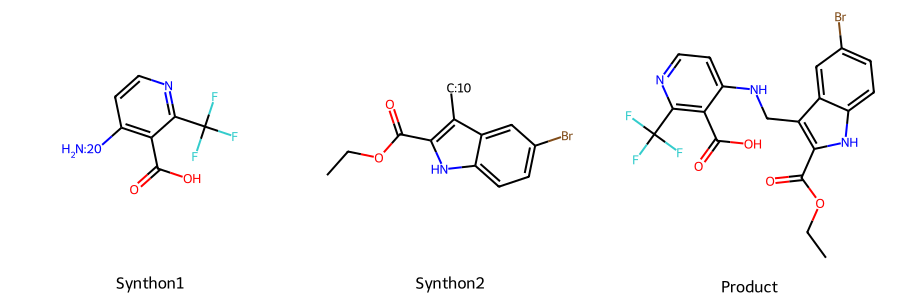

In [ ]:
Draw.MolsToGridImage([s1.mol, s2.mol, product[0].mol], legends=['Synthon1', 'Synthon2', 'Product'],
                    subImgSize=(300,300))

A note on working with synthons:

In the above, synthon1 and synthon2 still have reactive groups present on the molecule (carboxylic acid and carboxylic ester). This is because we generate a variety of synthons for each input building block based on the functional groups and reaction pathways available (see image below).

If you want to ensure specific reactive groups or protecting groups aren't present on final molecules, use a SMARTS filter in your template to eliminate them

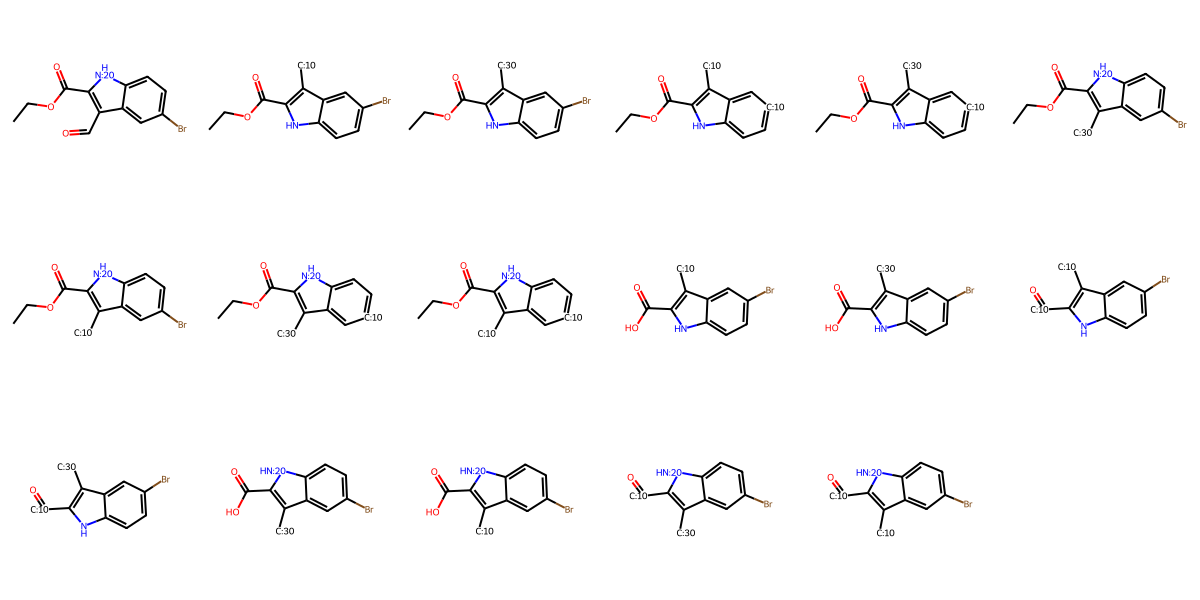

In [ ]:
Draw.MolsToGridImage([i.mol for i in molecule_to_synthon(s2.data['parents'][0])], molsPerRow=6)

## Define Assembly Schema

Now we define how our building blocks will fit together.

First we define our leaf nodes with the `SynthonLeafNode` class. Each leaf node has a name, a set of `n_func` values, and a template.

The `n_func` values define how many functional groups a building block is allowed to have. So `n_func=set([1])` would only allow building blocks with 1 functional group. `n_func=set([2,3])` would allow building blocks with 2-3 functional groups.

Note that as discussed above, `n_func` looks at the _annotated_ functional groups on the synthon, so will not exclude multi-functional building blocks with un-annotated groups.

Since we want to assemble two building blocks into a final molecule, we will set `n_func=set([1])` for each building block:

In [ ]:
bb1 = SynthonLeafNode('bb1', set([1]), bb_template)
bb2 = SynthonLeafNode('bb2', set([1]), bb_template)

Now we make the product node with the `SynthonNode` class, passing in our input nodes and reaction universe

In [ ]:
prod = SynthonNode('product', bb1, bb2, rxn_universe, set([0]), full_template)

## Assemble Library

To assemble, first we run `prod.build_assembly_pools(synthons)` which builds a dictionary of assembly pools based on which synthons match the `n_func` and template specifications at the leaf nodes.

Then we create the `AssemblyInputs` and pass them to `prod.assemble(assembly_inputs)`

In [ ]:
assembly_dict = prod.build_assembly_pools(synthons)
assembly_dict

{'bb1': AssemblyPool: 180 items, 'bb2': AssemblyPool: 180 items}

In [ ]:
assembly_inputs = AssemblyInputs(assembly_dict, 1000, 1000)

In [ ]:
assembled = prod.assemble(assembly_inputs)
assembled

bb1
bb2
product


AssemblyPool: 1497 items

Now we can review the assembled molecules. We can see some of these still contain reactive groups. These can be triaged if needed by adding additional smarts filters

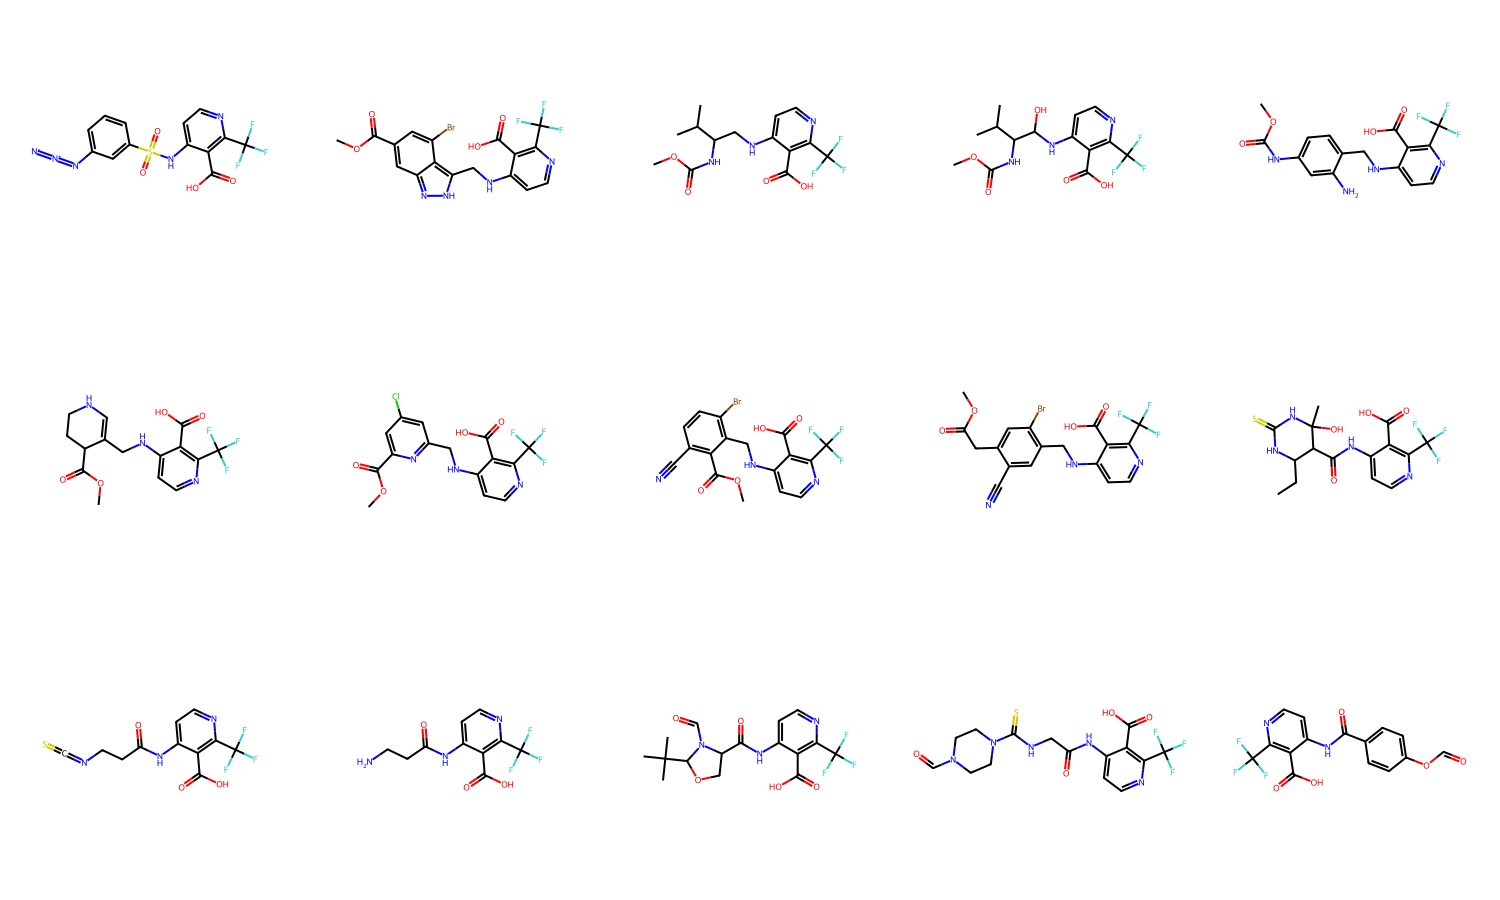

In [ ]:
Draw.MolsToGridImage([assembled[i].mol for i in range(15)], molsPerRow=5, subImgSize=(300,300))

## Other Assembly Schemas

Consider assembling 3 building blocks. Our assembly schema would follow:
* select first building block
* select second building block
* select matching reactions
* react and generate products
* select third building block
* select matching reactions
* react and generate products

We may want to impose different potential reactions at each step. We can do this by specifying different `ReactionUniverse` at the different product nodes. An example schema would look something like this:

```python
bb1 = SynthonLeafNode('bb1', set([1]), bb_template1) # first building block with 1 functional group
bb2 = SynthonLeafNode('bb2', set([2]), bb_template2) # middle building block with 2 functional groups
bb3 = SynthonLeafNode('bb3', set([3]), bb_template3) # final building block with 1 functional group

product1 = SynthonNode('product1', bb1, bb2, rxn_universe1, 
                       set([1]), prod1_template) # first product with 1 remaining functional group

product2 = SynthonNode('product2', product1, bb3, rxn_universe2, 
                       set([0]), prod2_template) # final product with 0 remaining functional groups
```